# DeepDive

Das folgende Jupyter Notebook stellt ein optimiertes neuronales Netz bezüglich der Accuracy und dessen Ergebnisse dar. Die ausführliche Dokumentation mit dem Namen **2014335_DD.pdf** ist in der GitHub-Repository zu finden.

## Präparation

Importieren von, für den Code benötigten, Packages. Dafür ist Installation von matplotlib, seaborn und tensorflow notwendig.

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [ ]:
pip install tensorflow

In [ ]:
from IPython.display import display, clear_output
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

import importlib

import tensorflow as tf        
print('Tensorflow version:', tf.__version__, '(Expected 2.7.0)')

## MNIST-Datensatz

Das Laden der Trainings- und der Tesdaten des MNIST-Datensatzes ist in keras mit einer Zeile möglich. Nach der Shape-Ausgabe lässt sich in diesem Datensatz erkennen, dass 60.000 Trainingsdaten und 10.000 Validierungs- bzw. Testdaten vorhanden sind und dass die Dimension der Y-Daten und der X-Daten unterschiedlich sind. Weiterhin werden die ersten 25 samples aus dem Set geplottet.

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)

 Plot of the first 25 samples in the MNIST training set


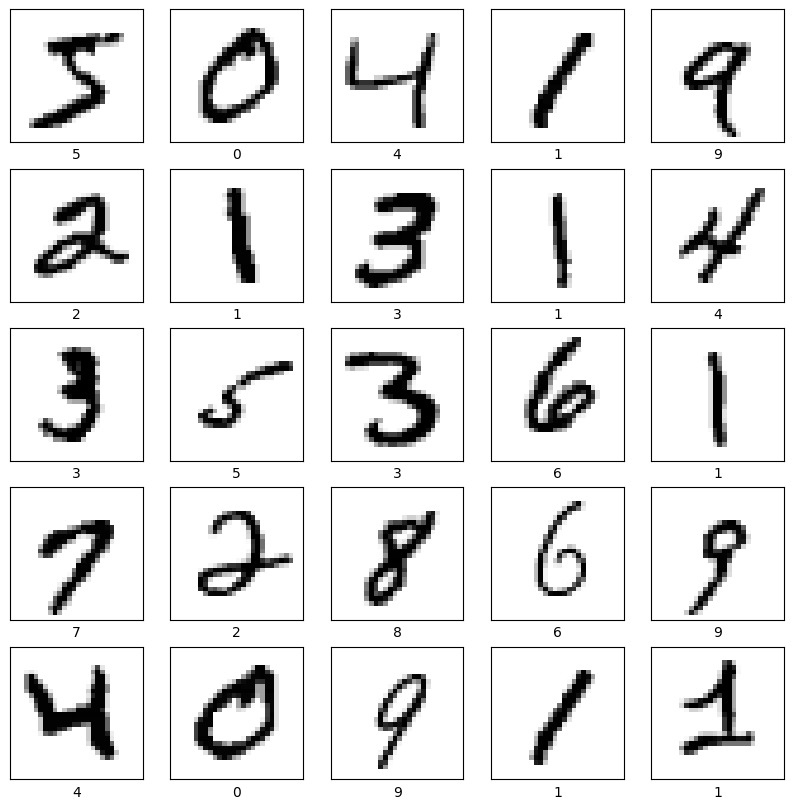

In [5]:
# Loading the MNIST dataset in one line
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

# Plotting data samples
print('\n Plot of the first 25 samples in the MNIST training set')
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [ ]:
x_train_normalized = x_train/255 
x_test_normalized = x_test/255 

# in the next step, we also need to reshape our input to fit our input layer later on. 
# This is due to keras expecting a definition for how many channels your input sample has, as we 
# deal with gray scale this is 1.
x_train= x_train_normalized.reshape(-1, 28, 28, 1)
x_test = x_test_normalized.reshape(-1, 28, 28, 1)

## Architektur des neuronalen Netzes

Das neuronale Netz wird 'bambi' genannt. Bei dem Netz handelt es sich um ein Convolutional Neural Network. Im ersten Teil werden 3 Convolutional-Layer mit jeweils 64 Filter, einer Kernel-Größe von 5x5 und die Max-Pooling-Layer definiert. Außerdem werden ReLu Aktivierungsfunktionen festgelegt. Zwischen Den Convolutional-Layer und den Hidden-Dense-Layer befindet sich das Flatten-Layer zur Dimensionalitätswandlung (von 2D auf 1D). Nach dem Faltten-Layer folgen 3 Hidden-Layer und das Output-Layer mit den 10 Neuronen. Für das Ausgangslayer wird die Softmax Aktivierungsfunktion verwendet.

In [7]:
bambi = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.07)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(10, activation='softmax')
])

In [8]:
bambi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1

## Vorbereitung für das Training

Hier wird die Loss-Funktion, sowie der Optimizer definiert. Außerdem wird hier die Zielsetzung der Projektarbeit deutlich durch die Metrik 'accuracy'.

In [ ]:
# Define your loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

print(-tf.math.log(1/10))

sampleID = 100
loss_fn(y_train[:1], bambi(x_train[sampleID-1:sampleID]).numpy()).numpy()

In [ ]:
bambi.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## Train, the model

Das Modell wird über 25 Epochen hinweg bei einer Batch-Size von 32 trainiert und anschließend auf die Validierungsdaten getestet. Obwohl die kleine Batch-Size das Training verlangsamt, trägt sie dazu bei, eine hohe Genauigkeit zu erzielen. Nach dem Training wird das Netz als .h5-Datei abgespeichert und muss nicht nochmal trainiert werden. Tensorboard wird nicht verwendet.

In [ ]:
import datetime
import os
%load_ext tensorboard

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
bambi.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size=32,
    shuffle = True,
    validation_data=(x_test, y_test),
    #callbacks=[tensorboard_callback]
)

In [ ]:
# This line would start up tensorboard for you
# %tensorboard --logdir logs

In [ ]:
model_name = 'bambi.h5'
bambi.save(model_name, save_format='h5')

print('Success! You saved Bambi as: ', model_name)

## Evaluating Bambi

Für die Bewertung muss zuerst das gewünschte Modell geladen werden. Anschließend erfolgt die Vorhersage der Testdaten durch das Modell und basierend darauf wird die Leistung des Netzwerks evaluiert. 196 Bilder zeigen dann, ob die Ziffern richtig gelabelt werden konnten. Außerdem kann der Accuracy-Wert für dieses Netz ausgegeben werden. Für dieses Modell ergibt sich eine bemerkenswerte Genauigkeit von 99,52%.

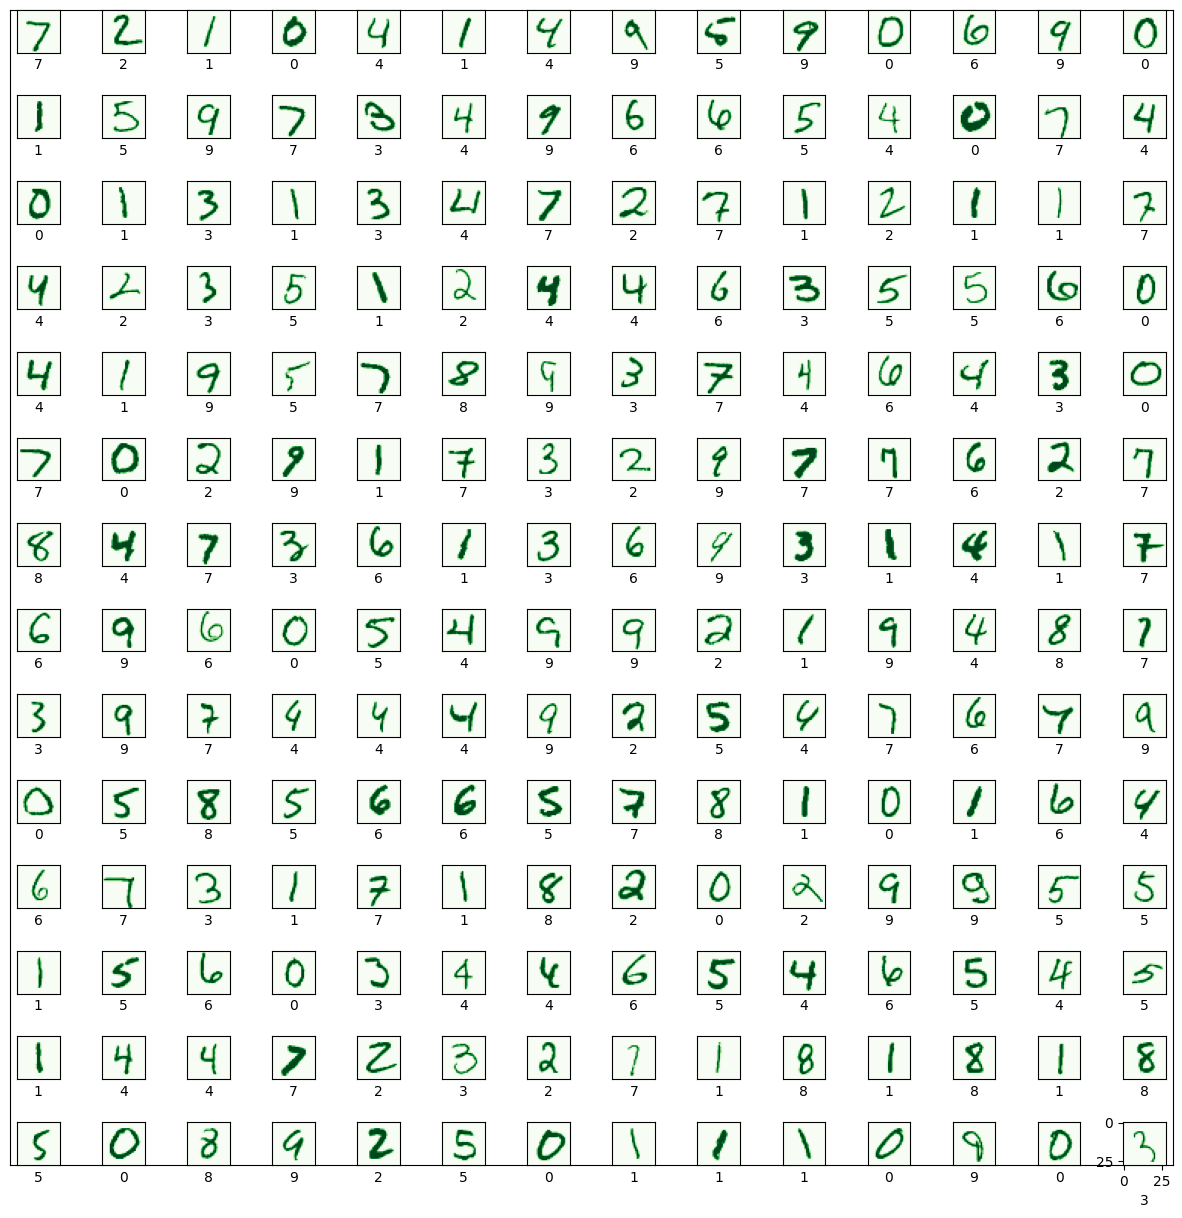

In [14]:
numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):    
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test_normalized[plot_index].reshape((28, 28)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

In [12]:
# load a saved bambi configuration you want to evaluate
model_name = 'bambi.h5'
bambi_reloaded = tf.keras.models.load_model(model_name)

# Let Bambi predict on the test set, so we have some data to evaluate his performance.
predictions = bambi_reloaded.predict([x_test])

# Remember that the prediction of Bambi is a probability distribution over all ten-digit classes
# We want him to assign the digit class with the highest probability to the sample.
predictions = np.argmax(predictions, axis=1)
#pd.DataFrame(predictions)

313/313 [==============================] - 7s 23ms/step


In [16]:
(test_loss, test_acc) = bambi_reloaded.evaluate(x_test, y_test)
print("Loss: ", test_loss)
print("Accuracy: ",test_acc)

313/313 [==============================] - 7s 22ms/step - loss: 0.0510 - accuracy: 0.9952
Loss:  0.05096404254436493
Accuracy:  0.995199978351593


## Confusion Matrix

Die Confusion-Matrix stellt ebenfalls dar, wie gut das Netz Ziffer klassifizieren konnte. Auf der horizontalen Achse sind die tatsächlichen und auf der vertikalen Achse die vorhergesagten Klassen/Ziffern. Das bambi-Netzwerk zeigt eine präzise Zuordnung der Ziffern, wie durch die Diagonale der Matrix deutlich wird, und weist nur geringfügige Abweichungen auf.

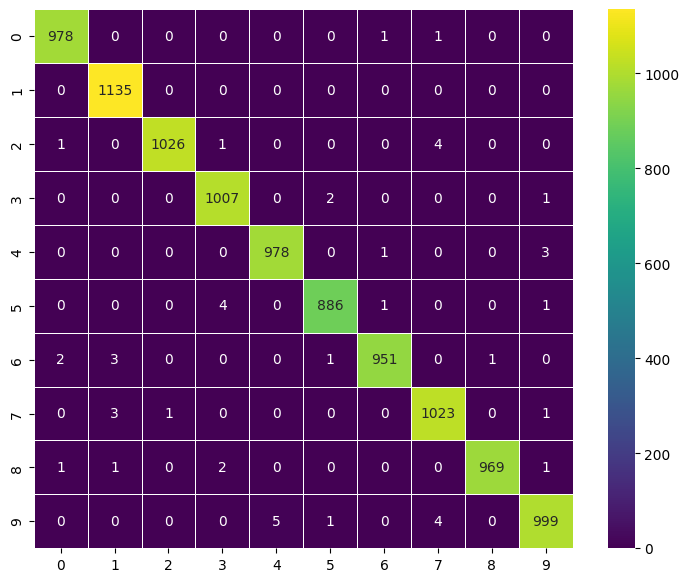

In [17]:
confusion_matrix = tf.math.confusion_matrix(y_test, predictions)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.7,
    fmt="d",
    square=True,
    ax=ax,
    cmap="viridis",
)
plt.show()